In [1]:
import pandas as pd

# File path
tle_file = 'starlink.txt'

# Read TLE lines
with open(tle_file, 'r') as f:
    lines = f.readlines()

# Lists to store satellite data
satellites = []
inclinations = []
altitudes = []
eccentricities = []

# Loop through every 3 lines (1 satellite)
for i in range(0, len(lines), 3):
    name = lines[i].strip()
    line1 = lines[i+1].strip()
    line2 = lines[i+2].strip()
    
    # Extract numeric orbital parameters
    inclination = float(line2[8:16].strip())
    eccentricity = float("0."+line2[26:33].strip())
    mean_motion = float(line2[52:63].strip())  # rev/day
    
    # Approximate altitude (km)
    mu = 398600.4418  # km^3/s^2, Earth's gravitational constant
    n = mean_motion * 2*3.1415926535 / 86400  # rad/s
    a = (mu / n**2) ** (1/3)
    altitude = a - 6371  # subtract Earth radius
    
    # Append to lists
    satellites.append(name)
    inclinations.append(inclination)
    altitudes.append(altitude)
    eccentricities.append(eccentricity)

# Create DataFrame
df = pd.DataFrame({
    'Satellite': satellites,
    'Inclination': inclinations,
    'Altitude_km': altitudes,
    'Eccentricity': eccentricities
})

# Save CSV
df.to_csv('satellite_data.csv', index=False)
print("Saved CSV as satellite_data.csv")



Saved CSV as satellite_data.csv


In [2]:
import pandas as pd

# Load the CSV you created
data = pd.read_csv('satellite_data.csv')

# Quick look
print(data.head())
print(data.info())


       Satellite  Inclination  Altitude_km  Eccentricity
0  STARLINK-1008      53.0514   554.359411      0.000132
1  STARLINK-1010      53.0513   345.228201      0.001035
2  STARLINK-1011      53.0505   374.365737      0.000671
3  STARLINK-1012      53.0497   554.361955      0.000192
4  STARLINK-1015      53.0438   289.208218      0.000148
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8281 entries, 0 to 8280
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Satellite     8281 non-null   object 
 1   Inclination   8281 non-null   float64
 2   Altitude_km   8281 non-null   float64
 3   Eccentricity  8281 non-null   float64
dtypes: float64(3), object(1)
memory usage: 258.9+ KB
None


In [3]:

# Fill missing values only in numeric columns
numeric_cols = data.select_dtypes(include='number').columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())



In [4]:
# Convert Inclination to radians
import numpy as np
data['Inclination_rad'] = np.deg2rad(data['Inclination'])

# Optional: normalize altitude (0-1 scale)
data['Altitude_norm'] = (data['Altitude_km'] - data['Altitude_km'].min()) / (data['Altitude_km'].max() - data['Altitude_km'].min())


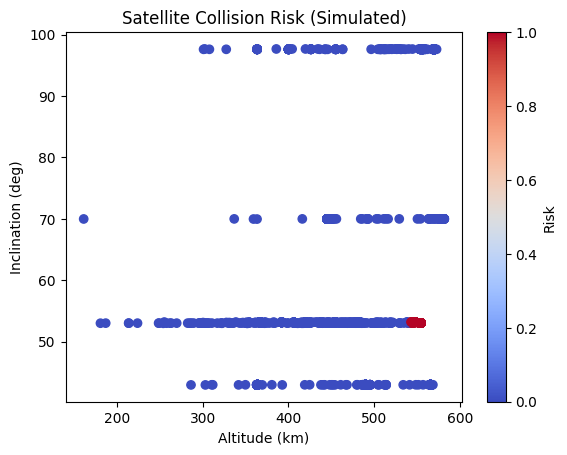

0    6138
1    2143
Name: Collision_risk, dtype: int64


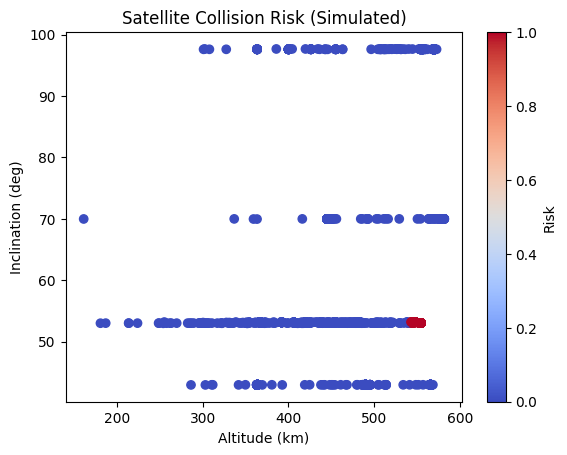

In [5]:
# Simple rule: high-altitude and similar inclinations → higher collision risk
data['Collision_risk'] = 0  # initialize as safe

# Example simulation: altitudes 540-560 km AND inclinations ~53 deg → risky
data.loc[(data['Altitude_km'].between(540, 560)) & 
         (data['Inclination'].between(52.5, 53.5)), 'Collision_risk'] = 1
import matplotlib.pyplot as plt

plt.scatter(data['Altitude_km'], data['Inclination'], c=data['Collision_risk'], cmap='coolwarm')
plt.xlabel('Altitude (km)')
plt.ylabel('Inclination (deg)')
plt.title('Satellite Collision Risk (Simulated)')
plt.colorbar(label='Risk')
plt.show()

# Check
print(data['Collision_risk'].value_counts())
import matplotlib.pyplot as plt

plt.scatter(data['Altitude_km'], data['Inclination'], c=data['Collision_risk'], cmap='coolwarm')
plt.xlabel('Altitude (km)')
plt.ylabel('Inclination (deg)')
plt.title('Satellite Collision Risk (Simulated)')
plt.colorbar(label='Risk')
plt.show()


In [6]:
from sklearn.model_selection import train_test_split

# Features: numeric columns
X = data[['Altitude_km', 'Inclination_rad', 'Eccentricity']]

# Target: simulated collision risk
y = data['Collision_risk']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training samples:", len(X_train))
print("Test samples:", len(X_test))


Training samples: 6624
Test samples: 1657


In [7]:
from sklearn.linear_model import LogisticRegression

# Initialize model
model = LogisticRegression()

# Train
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)


In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Detailed report
print(classification_report(y_test, y_pred))


Accuracy: 0.5872057936028968
Confusion Matrix:
 [[973 235]
 [449   0]]
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      1208
           1       0.00      0.00      0.00       449

    accuracy                           0.59      1657
   macro avg       0.34      0.40      0.37      1657
weighted avg       0.50      0.59      0.54      1657



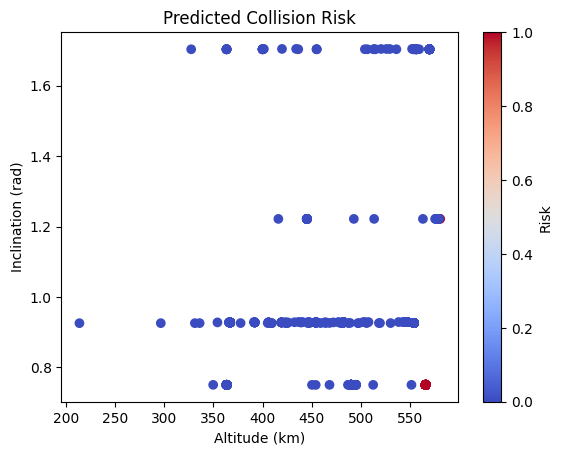

In [9]:
import matplotlib.pyplot as plt

plt.scatter(X_test['Altitude_km'], X_test['Inclination_rad'], c=y_pred, cmap='coolwarm')
plt.xlabel('Altitude (km)')
plt.ylabel('Inclination (rad)')
plt.title('Predicted Collision Risk')
plt.colorbar(label='Risk')
plt.show()


In [10]:
import pickle

# After training
with open("collision_model.pkl", "wb") as f:
    pickle.dump(model, f)   # save the full trained model object


In [11]:
data

,Satellite,Inclination,Altitude_km,Eccentricity,Inclination_rad,Altitude_norm,Collision_risk
0,STARLINK-1008,53.0514,554.359411,0.000132,0.925922,0.934026,1
1,STARLINK-1010,53.0513,345.228201,0.001035,0.925920,0.437719,0
2,STARLINK-1011,53.0505,374.365737,0.000671,0.925906,0.506868,0
3,STARLINK-1012,53.0497,554.361955,0.000192,0.925892,0.934032,1
4,STARLINK-1015,53.0438,289.208218,0.000148,0.925789,0.304773,0
...,...,...,...,...,...,...,...
8276,STARLINK-35042,53.1599,365.920475,0.000094,0.927815,0.486825,0
8277,STARLINK-35038,53.1589,354.048395,0.000094,0.927798,0.458651,0
8278,STARLINK-35037,53.1588,354.074646,0.000088,0.927796,0.458713,0
8279,STARLINK-35089,53.1582,354.065321,0.000126,0.927786,0.458691,0


In [12]:
# Save the updated dataset with labels
data.to_csv("satellite_data.csv", index=False)
print("✅ Updated satellite_data.csv saved with collision_risk column")


✅ Updated satellite_data.csv saved with collision_risk column
